In [1]:
%%capture
!pip install marqo

In [1]:
from marqo import Client
from marqo.errors import MarqoApiError

In [2]:
mq = Client()

In [3]:
index_name = "stable-diffusion-open-prompts"

In [4]:
index = mq.index(index_name)

In [5]:
index.get_stats()

{'numberOfDocuments': 907}

In [23]:
results = index.search("flirtatious")

In [24]:
results["hits"][0]

{'raw_discord_data_num_step': 50.0,
 'raw_discord_data_cfg_scale': 7.0,
 'raw_discord_data_timestamp': 1659884301.0,
 'local_image_location': 'http://host.docker.internal:8222/./artifacts/sample_prompts:v2/sample_prompts/love_-n_6_-i_-S_1220659097_ts-1659884301_idx-5.png',
 'raw_discord_data_is_grid': 0.0,
 'raw_discord_data_height': 512,
 'prompt': '“love”',
 'raw_discord_data_num_generations': 6.0,
 'raw_discord_data_seed': 1220659097.0,
 'raw_discord_data_width': 512,
 '_id': 'cda17cb4-fabb-4131-b8dc-19851bdbebc5',
 '_highlights': {'prompt': '“love”'},
 '_score': 0.9318731}

In [25]:
from PIL import Image
import requests

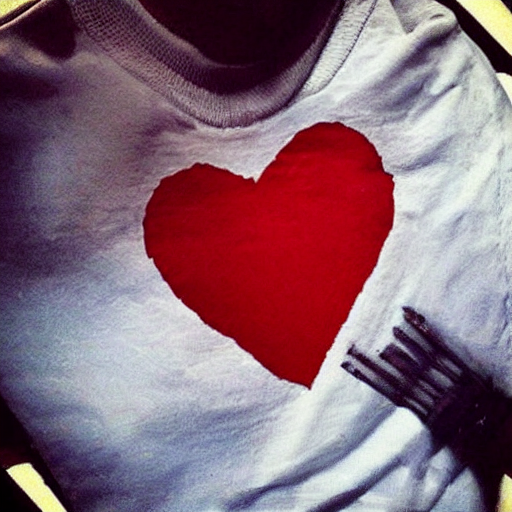

In [33]:
pic = results["hits"][0]["local_image_location"]
if pic.startswith("http://host.docker.internal:8222/"):
    #This still only gets the image from local
    pic_url = 'http://localhost:8222/' + pic.split("http://host.docker.internal:8222/")[1]
    image = Image.open(requests.get(pic_url, stream=True).raw)
image

In [34]:
results = index.search('https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Standing_Hippopotamus_MET_DP248993.jpg/440px-Standing_Hippopotamus_MET_DP248993.jpg')

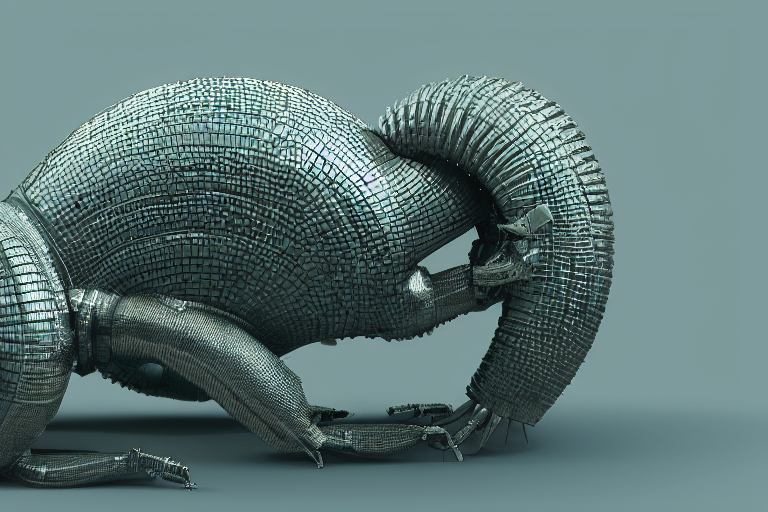

In [35]:
pic = results["hits"][0]["local_image_location"]
if pic.startswith("http://host.docker.internal:8222/"):
    #This still only gets the image from local
    pic_url = 'http://localhost:8222/' + pic.split("http://host.docker.internal:8222/")[1]
    image = Image.open(requests.get(pic_url, stream=True).raw)
image